# 出力層の重みの初期値を線形回帰で設定する

* scikit-learn の iris データを例に、ai-chan で機械学習をする
* 出力層(L層)の重みW,bは、学習用データXを 1層からL-1層まで流した出力Z(L-1) と 学習用データの教師値Y の間で線形回帰を行ったもの\
* 簡単な統計処理でできるところまでやっときましょうと言う発想
* なんか、めちゃくちゃいい結果が出たんだけど、他でこういうことをやっているという話を聞いたことがない。なんかまずいのかな？それとも盲点だった？

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

import sys,os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from ai_chan import nnet
from ai_chan import layer
from ai_chan import util
from ai_chan import grad
from ai_chan import func
from ai_chan import weight

# データの読み込み
* 1列が1つのデータセットになるように、読み込んだデータを転置する
* 機械学習の基本のキ → 教師データを学習用と、検証用に分ける

In [2]:
# データセットのロード
# iris.data = [(がく片の長さ , がく片の幅 , 花びらの長さ , 花びらの幅)]
iris = datasets.load_iris()
# データをシャッフルする (ミソ!)
np.random.shuffle(iris.data)

x_vals = np.array([x[0:3] for x in iris.data])
d_vals = np.array([x[3] for x in iris.data])

data_size = len(x_vals)
train_size = int(data_size * 0.8)
test_size = data_size - train_size

x_train = x_vals[0:train_size].T
d_train = d_vals[0:train_size].T

x_eval = x_vals[train_size:data_size].T
d_eval = d_vals[train_size:data_size].T

print ("total:{} = train:{} + test:{}".format(data_size, len(x_train[0]), len(x_eval[0])))

total:150 = train:120 + test:30


# 機械学習
* 学習率は、0.001
* 20000 回学習を行う

In [3]:
net = nnet.SimpleNet()

# 入力データを(初期状態で)標準化スコアに変換する前処理層
# 3→6
net.add_pre_layer(layer.Normalize(), x=x_vals.T)

# 中間層は 6→60
net.add_layer(60)

# 出力層は 60→1 初期状態で線形回帰を行うW[L],b[L]を設定
#net.add_layer(1, layer_factory=layer.Random(), activate_function=func.IdentityMapping())
net.add_post_layer(x_train, d_train)

# 学習係数は 0.001固定 (呼び出し回数で減衰させるとうまく収束しない)
# net.set_learning_rate(grad.Shrink())

# 正則化（重み減衰)
# net.set_weight_decay(weight.L1Decay())
net.set_weight_decay(weight.L2Decay())
# net.set_weight_decay(weight.LmaxDecay())

# 訓練誤差
tx = []
te = []
# 汎化誤差
gx = []
ge = []

for cnt in range(0, 20000):
    # 順伝搬 (評価用)
    gy = net.forward(x_eval)

    # 誤差評価 (評価用)
    gx.append(cnt)
    error = util.least_square_average(d_eval, gy)
    ge.append(error)

    # 順伝搬 (訓練用)
    y = net.forward(x_train)

    # 誤差評価 (訓練用)
    tx.append(cnt)
    error = util.least_square_average(d_train, y)
    te.append(error)

    # 逆伝搬
    dEdW, dEdB = net.backward(d_train, y)
    # パラメータ修正
    net.adjust_network(dEdW, dEdB)

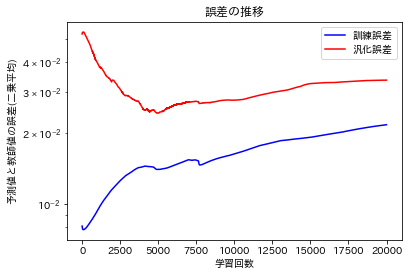

In [4]:
plt.figure()
plt.title("誤差の推移")
plt.xlabel("学習回数")
plt.ylabel("予測値と教師値の誤差(二乗平均)")

plt.yscale("log")
plt.plot(tx, te, color='blue', label='訓練誤差')
plt.plot(gx, ge, color='red', label='汎化誤差')
plt.legend()
plt.show()

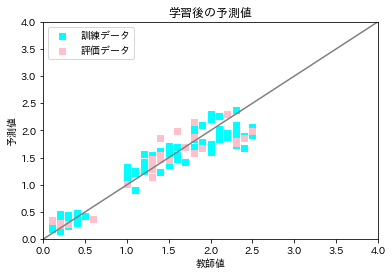

In [5]:
plt.figure()
plt.title("学習後の予測値")
plt.xlabel("教師値")
plt.ylabel("予測値")
plt.xlim(0.0, max(4.0, np.max(d_train), np.max(d_eval)))
plt.ylim(0.0, max(4.0, np.max(y), np.max(gy)))
plt.scatter(d_train.T, y.T, color="cyan", marker="s", label="訓練データ")
plt.scatter(d_eval.T, gy.T, color="pink", marker="s", label="評価データ")

x = np.arange(-10,10,0.1)
plt.plot(x, x, color="gray")
plt.legend()
plt.show()